In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, dimension, probability, quarentine = False, social_distance = False):
        self.num_agents = N
        self.grid = MultiGrid(dimension, 1, True)
        self.schedule = RandomActivation(self)
        self.healing_space = set()
        self.places = [[(i, 0)] for i in range(dimension)]
        self.quarentine = quarentine
        self.social_distance = social_distance
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            infected = np.random.choice([0,1], p=[1-probability,probability])
            if infected == 1:
                a.state = 1

        self.datacollector = DataCollector(
            agent_reporters={"State": "state"})
    
    def get_individuals(self, place):
        count = 0
        total = 0
        for (x,y) in place:
            temp =  self.grid.get_cell_list_contents((x, y))[0]
            if temp:
                if temp.isolated != 1:
                    if temp.state > 0:
                        count += 1
                    if temp.state > -2:
                        total += 1
        return count, total
    
    def clear_beds(self):
        for agent in self.schedule.agents:
            agent.transition()
            if agent.unique_id in self.healing_space and agent.state <= 0:
                self.healing_space.remove(agent.unique_id)
    
    def get_infections(self):
        inf = 0
        for agent in self.schedule.agents:
            if agent.state >= 1:
                inf += 1
        return inf

    def get_deaths(self):
        deaths = 0
        for agent in self.schedule.agents:
            if agent.state == -2:
                deaths += 1
        return deaths

    def get_cures(self):
        cure = 0
        for agent in self.schedule.agents:
            if agent.state == -1:
                cure += 1
        return cure   
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [3]:
# def get_places(d):
#     p1, p2 = [], []
#     g1, g2, g3, g4, g5 = [], [], [], [], []
#     for row in range(d):
#         for col in range(1):
#             if row < d/10:
#                 g1.append((row, col))
#             elif row < 2*d/10:
#                 g2.append((row, col))
#             elif row < 3*d/10:
#                 g3.append((row, col))
#             elif row < 4*d/10:
#                 g4.append((row, col))
#             elif row < 5*d/10:
#                 g5.append((row, col))
#             elif row < 6*d/10:
#                 p1.append((row, col))
#             elif row < 7*d/10:
#                 p2.append((row, col))
#     return [g1, g2, g3, g4, g5, p1, p2]

In [4]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = 0
        self.immunity = 0
        self.isolated = 0

    def move(self):
        movement = np.random.choice([1,2,3], p=[0.1, 0.2, 0.7])
        x = 7
        if movement == 1:
            x = np.random.choice([0,1])
        elif movement == 2:
            x = np.random.choice([2,3,4,5,6])
        y = self.model.random.randrange(self.model.grid.height)
        self.model.grid.place_agent(self, (x, y))

    def infect(self, places):
        if self.state >= 0:
            probabilities = [0.1 if self.model.social_distance else 0.5]*7
            for place, probability in zip(places, probabilities):
                n, total = self.model.get_individuals(place)
                probability = 0 if n == 0 else probability
                if self.pos in place:
                    self.state = max(self.state, np.random.choice([0,1], p=[1-probability,probability]))
                if self.immunity == 1:
                    self.state = 0
    
    def home(self):
        self.model.grid.place_agent(self, (7, 0))
        probability = 1
        if self.state >= 1:
            family = [elem for elem in range(math.floor(self.unique_id/4)*4, math.floor(self.unique_id/4)*4+4)]
            for member in family:
                if self.model.schedule.agents[member].state >= 0 and self.model.schedule.agents[member].pos == (7, 0):
                    self.model.schedule.agents[member].state = max(self.model.schedule.agents[member].state, np.random.choice([0,1], p=[1-probability,probability]))
    
    def transition(self):
        if self.state == 1:
            self.state = np.random.choice([1,2], p=[0.75, 0.25])
        elif self.state == 2:
            self.state = np.random.choice([2, 3, -1], p=[0.75, 0.10, 0.15])
        elif self.state == 3:
            self.state = np.random.choice([3, -1, -2], p=[0.75, 0.20, 0.05])
        if self.state == -1:
            self.immunity = 1
    
    def quarantine(self):
        if self.state == 2:
            self.isolated = np.random.choice([0,1], p=[0.80, 0.20])
        elif self.state == 3:
            self.isolated = 1
        if self.isolated == 1:
            self.model.healing_space.add(self.unique_id)
    
    def step(self):
        if self.model.quarentine == False:
            self.move()
            self.infect(self.model.places)
            self.home()
        else:
            if self.unique_id not in self.model.healing_space:
                self.move()
                self.infect(self.model.places)
                self.home()
            if len(self.model.healing_space)<100:
                self.quarantine()
            

In [5]:
def simulate(model):
    days = 0
    infections = []
    cures = []
    deaths = []
    beds = []
    while(model.get_infections() != 0):
        infections.append(model.get_infections())
        deaths.append(model.get_deaths())
        cures.append(model.get_cures())
        beds.append(len(model.healing_space))
        model.step()
        days += 1
        model.clear_beds()
    
    print("Days for survival", days)
    print("Casualties", model.get_deaths())
    print("Cures", model.get_cures())
    print("Max Quarentine Beds used", max(beds))

    plt.plot(infections)
    plt.plot(deaths)
    plt.plot(cures)
    plt.plot(beds)
    plt.gca().legend(('infections','deaths', 'cures', 'beds'))
    plt.show()

Days for survival 41
Casualties 86
Cures 914
Max Quarentine Beds used 0


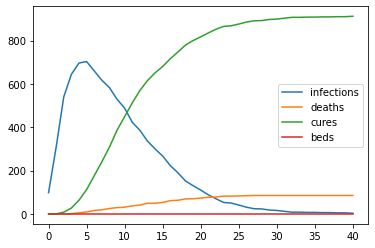

In [6]:
simulate(MoneyModel(1000, 8, 0.1))

Days for survival 41
Casualties 68
Cures 912
Max Quarentine Beds used 81


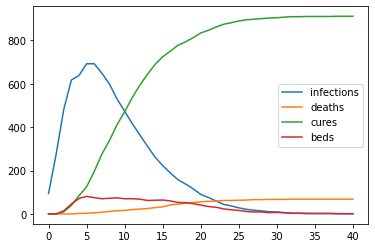

In [7]:
simulate(MoneyModel(1000, 8, 0.1, quarentine=True))

Days for survival 38
Casualties 31
Cures 513
Max Quarentine Beds used 76


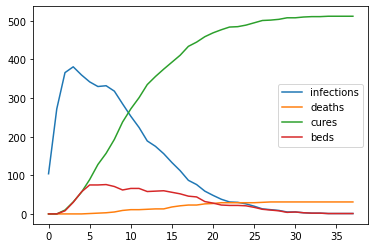

In [8]:
simulate(MoneyModel(1000, 8, 0.1, quarentine=True, social_distance=True))

Days for survival 50
Casualties 69
Cures 919
Max Quarentine Beds used 0


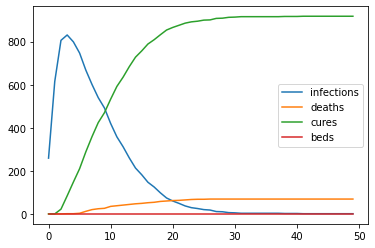

In [9]:
simulate(MoneyModel(1000, 8, 0.25))

Days for survival 39
Casualties 78
Cures 918
Max Quarentine Beds used 84


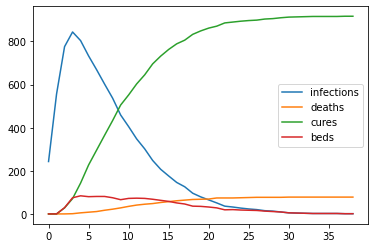

In [10]:
simulate(MoneyModel(1000, 8, 0.25, quarentine=True))

Days for survival 44
Casualties 62
Cures 814
Max Quarentine Beds used 79


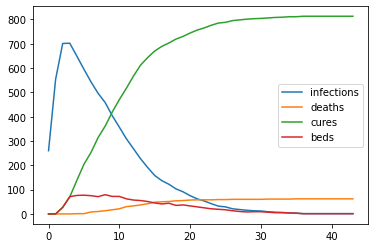

In [11]:
simulate(MoneyModel(1000, 8, 0.25, quarentine=True, social_distance=True))

Days for survival 43
Casualties 77
Cures 911
Max Quarentine Beds used 0


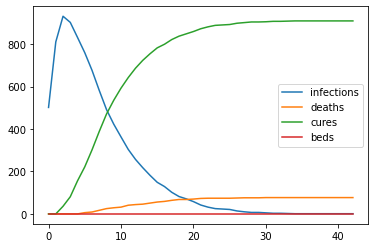

In [12]:
simulate(MoneyModel(1000, 8, 0.50))

Days for survival 44
Casualties 91
Cures 909
Max Quarentine Beds used 81


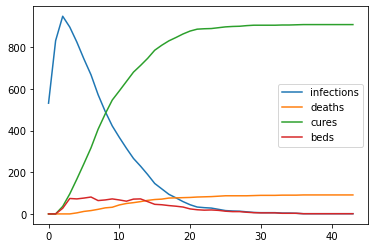

In [13]:
simulate(MoneyModel(1000, 8, 0.50, quarentine=True))

Days for survival 46
Casualties 93
Cures 883
Max Quarentine Beds used 79


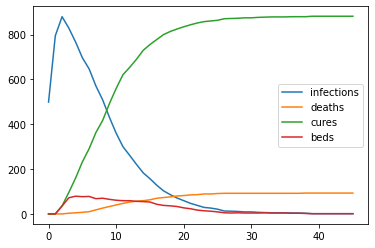

In [14]:
simulate(MoneyModel(1000, 8, 0.50, quarentine=True, social_distance=True))